In [1]:
%pylab inline
import numpy as np
import pandas as pd
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.style.use('bmh')

In [3]:
import seaborn as sns

# Intro

Pandas dataframes are a great tool for data exploration. But they have some limitations. One of them is that it's not possible to use geospatial information in exploratory data analysis. GeoPandas is aimed at solving this problem.

GeoPandas provides two abstractions: `GeoDataFrame` and `GeoSeries`. At their core, they are usual dataframes and series, but with geometry, provided as a dedicated entity for each row. This allows to perform more complex queries, for example:

- select all the rows, which are inside some area,
- select all the rows with underlying geometry area above threshold.

GeoPandas also provides a lot of typical geospatiial operations in a vectorized form similar to `apply`, `groupby` and `join`, as well as I/O operations like saving to PostGIS, or reading GeoJSON or shapefiles.

# Shapelly geometries

The main Python package, which provides geometry operations, is Shapely. It contains all the main geometry structures (points. lines, polygons, nulti-ppolygons, etc.) and common operations on them.

Shapely also knows how to visualize the geometry, which is very useful during EDA.

In [4]:
import shapely

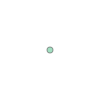

In [5]:
point = shapely.geometry.Point(0.25, 0.5)
point

In [6]:
point.area

0.0

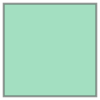

In [7]:
polygon = shapely.geometry.Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
polygon

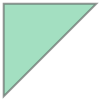

In [8]:
polygon = shapely.geometry.Polygon([(0, 0), (0, 1), (1, 1)])
polygon

In [9]:
polygon.area, polygon.bounds # <= it's easy to calculate area, get bounding box and so on

(0.5, (0.0, 0.0, 1.0, 1.0))

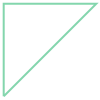

In [10]:
polygon.boundary

In [11]:
type(polygon.boundary), polygon.bounds

(shapely.geometry.linestring.LineString, (0.0, 0.0, 1.0, 1.0))

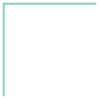

In [12]:
line = shapely.geometry.LineString([(0, 0), (0, 1), (1, 1)]) # <= note the difference
line

In [13]:
point.within(polygon) # <= check geospatial relations

True

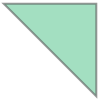

In [14]:
polygon_alt = shapely.geometry.Polygon([(0, 1), (1, 1), (1, 0)])
polygon_alt

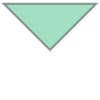

In [15]:
polygon.intersection(polygon_alt)

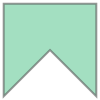

In [16]:
polygon.union(polygon_alt)

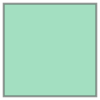

In [17]:
bbox = shapely.geometry.box(0.25, 0.25, 0.75, 0.75)
bbox

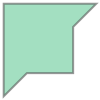

In [18]:
polygon.union(bbox)

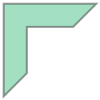

In [19]:
polygon.difference(bbox)

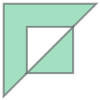

In [20]:
polygon.symmetric_difference(bbox)

# Reading shapefiles

There are many format to store geospatial data. One of common is shapefile. It's a binary format and is typically read with Fiona package of directly with GeoPandas. To experiment, we will download shapefile of London area from [London Datastore](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london). Specifically, we will use `London_Ward_CityMerged.shp`, extracted from `ESRI` directory in `statistical-gis-boundaries-london.zip`. Note, that you also need `.shx` file (it contains offset and other information for proper reading of shapefile).

In [21]:
london_areas = gpd.read_file("data/London_Ward_CityMerged.shp")

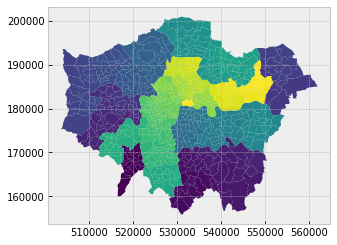

In [22]:
london_areas.plot(column=london_areas.index.values)

In [23]:
print(f"Total area, km2: {london_areas.area.sum()/1e6}")

Total area, km2: 1594.697014125


# Creating `GeoDataFrame`

Now that we know how to read some shapefiles and can use them to filter our data, we need to create an actual `GeoDataFrame`. Note, that we're using easting and northing, and compare it with our London shape.

In [24]:
df = pd.read_csv('data/accidents_2005_to_2007.csv.zip',
                 usecols=["Accident_Index", "Accident_Severity", "Number_of_Vehicles",
                          "Number_of_Casualties", "Location_Easting_OSGR", "Location_Northing_OSGR"])

In [25]:
gdf = gpd.GeoDataFrame(df[["Accident_Index", "Accident_Severity", "Number_of_Vehicles",
                           "Number_of_Casualties", "Number_of_Casualties"]],
                       geometry=gpd.points_from_xy(*df[["Location_Easting_OSGR", "Location_Northing_OSGR"]].values.T))
gdf

,Accident_Index,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Number_of_Casualties,geometry
0,200501BS00001,2,1,1,1,POINT (525680 178240)
1,200501BS00002,3,1,1,1,POINT (524170 181650)
2,200501BS00003,3,2,1,1,POINT (524520 182240)
3,200501BS00004,3,1,1,1,POINT (526900 177530)
4,200501BS00005,3,1,1,1,POINT (528060 179040)
...,...,...,...,...,...,...
570006,2.01E+12,3,1,1,1,POINT (322650 566300)
570007,2.01E+12,2,1,2,2,POINT (323710 566150)
570008,2.01E+12,3,1,1,1,POINT (336900 586230)
570009,2.01E+12,3,1,1,1,POINT (332390 567240)


Coordinates are provided in separate columns, hence, we have to create geomerties manually. In general, GeoPandas knows, how to handle `geometry` column in many formats, most common being WKT (Well Known Text). We can easily performed mixed queries:

In [26]:
gdf[gdf.within(london_areas.geometry.iloc[0]) & (gdf.Number_of_Vehicles==3)]

,Accident_Index,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Number_of_Casualties,geometry
20227,200501VK30050,3,3,2,2,POINT (518880 164050)
217913,200601VK30305,3,3,1,1,POINT (519030 164010)
405402,200701VK30187,3,3,1,1,POINT (517240 161580)
405426,200701VK30218,3,3,2,2,POINT (517870 163920)
405463,200701VK30259,3,3,1,1,POINT (519230 163960)
405479,200701VK30279,3,3,1,1,POINT (517650 163260)
405511,200701VK30314,3,3,1,1,POINT (517540 162510)


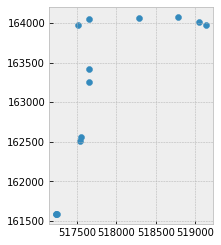

In [27]:
gdf[gdf.within(london_areas.geometry.iloc[0]) & (gdf.Accident_Severity<=2)].plot()

# Common operations

Imagine, that we want to calculate number of accidents by area. To do this, we need to perform spatial join operation. However, join will fail, if we have missing coordinates, so let's remove those from the dataframe:

In [28]:
gdf = gdf[df.Location_Easting_OSGR.notnull() & df.Location_Northing_OSGR.notnull()]

In [29]:
gpd = gpd.sjoin(gdf, london_areas)

/home/traveller/.local/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {})
  '(%s != %s)' % (left_df.crs, right_df.crs))


Great, we now know, in which city area each accident happened. Note, that resulting dataframe only contains those accident, which belong to London (see dataframe shape):

In [30]:
gpd

,Accident_Index,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Number_of_Casualties,geometry,index_right
0,200501BS00001,2,1,1,1,POINT (525680 178240),464
11,200501BS00014,3,2,1,1,POINT (526170 177690),464
47,200501BS70021,3,1,1,1,POINT (526290 177800),464
48,200501BS70023,3,2,2,2,POINT (526020 177850),464
97,200501BS70079,3,3,1,1,POINT (526090 177600),464
...,...,...,...,...,...,...,...
411135,200701ZT80282,3,2,1,1,POINT (524510 163690),369
411152,200701ZT80303,3,2,1,1,POINT (524280 163590),369
411155,200701ZT80317,3,2,2,2,POINT (524290 163570),369
411157,200701ZT80319,2,2,1,1,POINT (524500 163690),369


In [31]:
gpd.rename({"index_right":"city_area"}, axis=1, inplace=True)

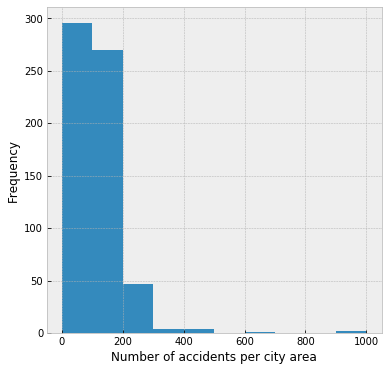

In [32]:
plt.figure(figsize=(6,6))
gpd.groupby("city_area").size().plot(kind="hist", range=(0, 1000), bins=10)
plt.xlabel("Number of accidents per city area");

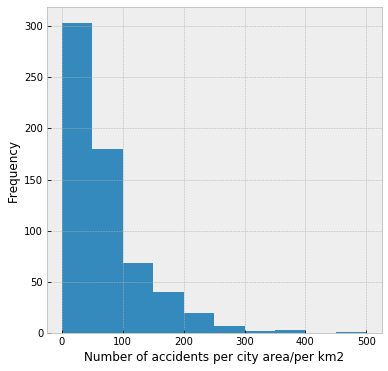

In [33]:
plt.figure(figsize=(6,6))
(1e6*gpd.groupby("city_area").size()/london_areas.area).plot(kind="hist", range=(0, 500), bins=10)
plt.xlabel("Number of accidents per city area/per km2");

With this basic knowledge, you may dig deeper into the topic and explore relations with, for example, some demographic information (you'll need to search for it!) or other information.